In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
import re
from functools import partial
import json

import numpy as np
from scipy.special import logit, expit
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch

In [3]:
def corners_nd(dims, origin=0.5):
    """generate relative box corners based on length per dim and
    origin point. 
    
    Args:
        dims (float array, shape=[N, ndim]): array of length per dim
        origin (list or array or float): origin point relate to smallest point.
    
    Returns:
        float array, shape=[N, 2 ** ndim, ndim]: returned corners. 
        point layout example: (2d) x0y0, x0y1, x1y0, x1y1;
            (3d) x0y0z0, x0y0z1, x0y1z0, x0y1z1, x1y0z0, x1y0z1, x1y1z0, x1y1z1
            where x0 < x1, y0 < y1, z0 < z1
    """
    ndim = int(dims.shape[1])
    corners_norm = np.stack(
        np.unravel_index(np.arange(2**ndim), [2] * ndim),
        axis=1).astype(dims.dtype)
    # now corners_norm has format: (2d) x0y0, x0y1, x1y0, x1y1
    # (3d) x0y0z0, x0y0z1, x0y1z0, x0y1z1, x1y0z0, x1y0z1, x1y1z0, x1y1z1
    # so need to convert to a format which is convenient to do other computing.
    # for 2d boxes, format is clockwise start with minimum point
    # for 3d boxes, please draw lines by your hand.
    if ndim == 2:
        # generate clockwise box corners
        corners_norm = corners_norm[[0, 1, 3, 2]]
    elif ndim == 3:
        corners_norm = corners_norm[[0, 1, 3, 2, 4, 5, 7, 6]]
    corners_norm = corners_norm - np.array(origin, dtype=dims.dtype)
    corners = dims.reshape([-1, 1, ndim]) * corners_norm.reshape(
        [1, 2**ndim, ndim])
    return corners

def rotation_3d_in_axis(points, angles, axis=0):
    # points: [N, point_size, 3]
    rot_sin = np.sin(angles)
    rot_cos = np.cos(angles)
    ones = np.ones_like(rot_cos)
    zeros = np.zeros_like(rot_cos)
    if axis == 1:
        rot_mat_T = np.stack([[rot_cos, zeros, -rot_sin], [zeros, ones, zeros],
                              [rot_sin, zeros, rot_cos]])
    elif axis == 2 or axis == -1:
        rot_mat_T = np.stack([[rot_cos, -rot_sin, zeros],
                              [rot_sin, rot_cos, zeros], [zeros, zeros, ones]])
    elif axis == 0:
        rot_mat_T = np.stack([[zeros, rot_cos, -rot_sin],
                              [zeros, rot_sin, rot_cos], [ones, zeros, zeros]])
    else:
        raise ValueError("axis should in range")

    return np.einsum('aij,jka->aik', points, rot_mat_T)

def center_to_corner_box3d(centers,
                           dims,
                           angles=None,
                           origin=(0.5, 0.5, 0.5),
                           axis=2):
    """convert kitti locations, dimensions and angles to corners
    
    Args:
        centers (float array, shape=[N, 3]): locations in kitti label file.
        dims (float array, shape=[N, 3]): dimensions in kitti label file.
        angles (float array, shape=[N]): rotation_y in kitti label file.
        origin (list or array or float): origin point relate to smallest point.
            use [0.5, 1.0, 0.5] in camera and [0.5, 0.5, 0] in lidar.
        axis (int): rotation axis. 1 for camera and 2 for lidar.
    Returns:
        [type]: [description]
    """
    # 'length' in kitti format is in x axis.
    # yzx(hwl)(kitti label file)<->xyz(lhw)(camera)<->z(-x)(-y)(wlh)(lidar)
    # center in kitti format is [0.5, 1.0, 0.5] in xyz.
    corners = corners_nd(dims, origin=origin)
    # corners: [N, 8, 3]
    if angles is not None:
        corners = rotation_3d_in_axis(corners, angles, axis=axis)
    corners += centers.reshape([-1, 1, 3])
    return corners

def corner_to_surfaces_3d(corners):
    """convert 3d box corners from corner function above
    to surfaces that normal vectors all direct to internal.

    Args:
        corners (float array, [N, 8, 3]): 3d box corners. 
    Returns:
        surfaces (float array, [N, 6, 4, 3]): 
    """
    # box_corners: [N, 8, 3], must from corner functions in this module
    surfaces = np.array([
        [corners[:, 0], corners[:, 1], corners[:, 2], corners[:, 3]],
        [corners[:, 7], corners[:, 6], corners[:, 5], corners[:, 4]],
        [corners[:, 0], corners[:, 3], corners[:, 7], corners[:, 4]],
        [corners[:, 1], corners[:, 5], corners[:, 6], corners[:, 2]],
        [corners[:, 0], corners[:, 4], corners[:, 5], corners[:, 1]],
        [corners[:, 3], corners[:, 2], corners[:, 6], corners[:, 7]],
    ]).transpose([2, 0, 1, 3])
    return surfaces

def corner_to_surfaces_3d_jit(corners):
    """convert 3d box corners from corner function above
    to surfaces that normal vectors all direct to internal.

    Args:
        corners (float array, [N, 8, 3]): 3d box corners. 
    Returns:
        surfaces (float array, [N, 6, 4, 3]): 
    """
    # box_corners: [N, 8, 3], must from corner functions in this module
    num_boxes = corners.shape[0]
    surfaces = np.zeros((num_boxes, 6, 4, 3), dtype=corners.dtype)
    corner_idxes = np.array([
        0, 1, 2, 3, 7, 6, 5, 4, 0, 3, 7, 4, 1, 5, 6, 2, 0, 4, 5, 1, 3, 2, 6, 7
    ]).reshape(6, 4)
    for i in range(num_boxes):
        for j in range(6):
            for k in range(4):
                surfaces[i, j, k] = corners[i, corner_idxes[j, k]]
    return surfaces

def surface_equ_3d_jitv2(surfaces):
    # polygon_surfaces: [num_polygon, num_surfaces, num_points_of_polygon, 3]
    num_polygon = surfaces.shape[0]
    max_num_surfaces = surfaces.shape[1]
    normal_vec = np.zeros((num_polygon, max_num_surfaces, 3), dtype=surfaces.dtype)
    d = np.zeros((num_polygon, max_num_surfaces), dtype=surfaces.dtype)
    sv0 = surfaces[0, 0, 0] - surfaces[0, 0, 1]
    sv1 = surfaces[0, 0, 0] - surfaces[0, 0, 1]
    for i in range(num_polygon):
        for j in range(max_num_surfaces):
            sv0[0] = surfaces[i, j, 0, 0] - surfaces[i, j, 1, 0]
            sv0[1] = surfaces[i, j, 0, 1] - surfaces[i, j, 1, 1]
            sv0[2] = surfaces[i, j, 0, 2] - surfaces[i, j, 1, 2]
            sv1[0] = surfaces[i, j, 1, 0] - surfaces[i, j, 2, 0]
            sv1[1] = surfaces[i, j, 1, 1] - surfaces[i, j, 2, 1]
            sv1[2] = surfaces[i, j, 1, 2] - surfaces[i, j, 2, 2]
            normal_vec[i, j, 0] = (sv0[1] * sv1[2] - sv0[2] * sv1[1])
            normal_vec[i, j, 1] = (sv0[2] * sv1[0] - sv0[0] * sv1[2])
            normal_vec[i, j, 2] = (sv0[0] * sv1[1] - sv0[1] * sv1[0])
            
            d[i, j] = -surfaces[i, j, 0, 0] * normal_vec[i, j, 0] - \
                      surfaces[i, j, 0, 1] * normal_vec[i, j, 1] - \
                       surfaces[i, j, 0, 2] * normal_vec[i, j, 2]
    return normal_vec, d

def _points_in_convex_polygon_3d_jit(points,
                                    polygon_surfaces,
                                    normal_vec, d,
                                    num_surfaces=None):
    """check points is in 3d convex polygons.
    Args:
        points: [num_points, 3] array.
        polygon_surfaces: [num_polygon, max_num_surfaces, 
            max_num_points_of_surface, 3] 
            array. all surfaces' normal vector must direct to internal.
            max_num_points_of_surface must at least 3.
        num_surfaces: [num_polygon] array. indicate how many surfaces 
            a polygon contain
    Returns:
        [num_points, num_polygon] bool array.
    """
    max_num_surfaces, max_num_points_of_surface = polygon_surfaces.shape[1:3]
    num_points = points.shape[0]
    num_polygons = polygon_surfaces.shape[0]
    ret = np.ones((num_points, num_polygons), dtype=np.bool_)
    sign = 0.0
    for i in range(num_points):
        for j in range(num_polygons):
            for k in range(max_num_surfaces):
                if k > num_surfaces[j]:
                    break
                sign = points[i, 0] * normal_vec[j, k, 0] \
                     + points[i, 1] * normal_vec[j, k, 1] \
                     + points[i, 2] * normal_vec[j, k, 2] + d[j, k]
                if sign >= 0:
                    ret[i, j] = False
                    break
    return ret


def points_in_convex_polygon_3d_jit(points,
                                    polygon_surfaces,
                                    num_surfaces=None):
    """check points is in 3d convex polygons.
    Args:
        points: [num_points, 3] array.
        polygon_surfaces: [num_polygon, max_num_surfaces, 
            max_num_points_of_surface, 3] 
            array. all surfaces' normal vector must direct to internal.
            max_num_points_of_surface must at least 3.
        num_surfaces: [num_polygon] array. indicate how many surfaces 
            a polygon contain
    Returns:
        [num_points, num_polygon] bool array.
    """
    max_num_surfaces, max_num_points_of_surface = polygon_surfaces.shape[1:3]
    num_points = points.shape[0]
    num_polygons = polygon_surfaces.shape[0]
    if num_surfaces is None:
        num_surfaces = np.full((num_polygons,), 9999999, dtype=np.int64)
    normal_vec, d = surface_equ_3d_jitv2(polygon_surfaces[:, :, :3, :])
    # normal_vec: [num_polygon, max_num_surfaces, 3]
    # d: [num_polygon, max_num_surfaces]
    return _points_in_convex_polygon_3d_jit(points, polygon_surfaces, normal_vec, d, num_surfaces)

def points_in_rbbox(points, rbbox, z_axis=2, origin=(0.5, 0.5, 0.5)):
    rbbox_corners = center_to_corner_box3d(
        rbbox[:, :3], rbbox[:, 3:6], rbbox[:, 6], origin=origin, axis=z_axis)
    surfaces = corner_to_surfaces_3d(rbbox_corners)
    indices = points_in_convex_polygon_3d_jit(points[:, :3], surfaces)
    return indices

In [29]:
def camera_to_lidar(points, r_rect, velo2cam):
    points_shape = list(points.shape[0:-1])
    if points.shape[-1] == 3:
        points = np.concatenate([points, np.ones(points_shape + [1])], axis=-1)
    lidar_points = points @ np.linalg.inv((r_rect @ velo2cam).T)
    return lidar_points[..., :3]


def lidar_to_camera(points, r_rect, velo2cam):
    points_shape = list(points.shape[:-1])
    if points.shape[-1] == 3:
        points = np.concatenate([points, np.ones(points_shape + [1])], axis=-1)
    camera_points = points @ (r_rect @ velo2cam).T
    return camera_points[..., :3]


def box_camera_to_lidar(data, r_rect, velo2cam):
    xyz = data[:, 0:3]
    l, h, w = data[:, 3:4], data[:, 4:5], data[:, 5:6]
    r = data[:, 6:7]
    xyz_lidar = camera_to_lidar(xyz, r_rect, velo2cam)
    return np.concatenate([xyz_lidar, w, l, h, r], axis=1)


def box_lidar_to_camera(data, r_rect, velo2cam):
    xyz_lidar = data[:, 0:3]
    w, l, h = data[:, 3:4], data[:, 4:5], data[:, 5:6]
    r = data[:, 6:7]
    xyz = lidar_to_camera(xyz_lidar, r_rect, velo2cam)
    return np.concatenate([xyz, l, h, w, r], axis=1)

def change_box3d_center_(box3d, src, dst):
    dst = np.array(dst, dtype=box3d.dtype)
    src = np.array(src, dtype=box3d.dtype)
    box3d[..., :3] += box3d[..., 3:6] * (dst - src)

In [5]:
def regression_precision(y_true, y_pred, variance_pred, confidence):
    r"""(Kuleshov et al., 2018)
    Predicted value has an uncertainty. Given confidence p,
    the estimated region is derived inside which y_true lies with proba. p.
    The estimated region is equal to the p-confidence region.

    Parameters:
        y_true: float ndarray with shape (n_sample,)
        y_pred: float ndarray with shape (n_sample,)
        variance_pred: float ndarray with shape (n_sample,)
            Estimated variance \sigma^2 for each predicted y.
        confidence: float
            Threshold to count correct predctions.
    
    Returns:
        precision: float
    """
    sigma_pred = np.sqrt(variance_pred)
    region_lowers, region_uppers = stats.norm.interval(confidence, loc=y_pred, scale=sigma_pred)
    correct_count = np.sum((region_lowers <= y_true) & (y_true <= region_uppers))
    return correct_count / len(y_true)

def reg_calibration_curve(y_true, y_pred, variance_pred, n_bins):
    confidences = np.linspace(0.0, 1.0, n_bins, endpoint=True)
    precs = np.zeros(n_bins, dtype=np.float32)
    for i, conf in enumerate(confidences):
        precs[i] = regression_precision(y_true, y_pred, variance_pred, conf)
    return precs, confidences

def show_calibration(y_true, y_pred, variance_pred, n_bins):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted sigmas")
    plt.hist(np.sqrt(variance_pred), range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted sigma")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = reg_calibration_curve(y_true, y_pred, variance_pred, n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Prediction-confidences")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

In [14]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc-vonMises.config")
MODEL = os.environ.get("MODEL", "pointpillars-car-xyres_16-boxunc-vonMises")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"

/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16-boxunc-vonMises.config pointpillars-car-xyres_16-boxunc-vonMises
latest step: 296960


In [15]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

In [16]:
assert len(dets) == len(rawdets)

In [17]:
print(rawdets[0].keys())
print(dets[0].keys())
print(gts[0].keys())
print(gts[0]["annos"].keys())

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata', 'boxvariance_lidar'])
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'raw_detection_index', 'metadata', 'official/overlaps', 'official/3d_0.70/0/bin', 'official/3d_0.70/0/assigned_gt', 'official/3d_0.70/0/tp', 'official/3d_0.70/0/fp', 'official/3d_0.70/1/bin', 'official/3d_0.70/1/assigned_gt', 'official/3d_0.70/1/tp', 'official/3d_0.70/1/fp', 'official/3d_0.70/2/bin', 'official/3d_0.70/2/assigned_gt', 'official/3d_0.70/2/tp', 'official/3d_0.70/2/fp', 'num_points_in_det'])
dict_keys(['image', 'point_cloud', 'calib', 'annos'])
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'index', 'group_ids', 'difficulty', 'num_points_in_gt'])


In [19]:
assert all([np.allclose(det["score"], rdet["scores"][det["raw_detection_index"]]) for det, rdet in zip(dets, rawdets)])

In [30]:
data = {
    "y_true": [],
    "conf": [],
    "X": [],
    "Y": [],
    "Z": [],
    "varX": [],
    "varY": [],
    "varZ": [],
    "Xgt": [],
    "Ygt": [],
    "Zgt": [],
    "num_points_in_det": [],
    "sample_idx": [],
}

for i, (rawdet, det, gt) in enumerate(tqdm(zip(rawdets, dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/assigned_gt"]
    mask = result != -1 # collect only tp
    data["y_true"].append(np.where(det["official/3d_0.70/2/bin"][mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    raw_indices = det["raw_detection_index"][mask]
    # data["X"].append(det["location"][mask,0])
    # data["Y"].append(det["location"][mask,1])
    # data["Z"].append(det["location"][mask,2])
    data["X"].append(rawdet["box3d_lidar"][raw_indices,0])
    data["Y"].append(rawdet["box3d_lidar"][raw_indices,1])
    data["Z"].append(rawdet["box3d_lidar"][raw_indices,2])
    data["varX"].append(rawdet["boxvariance_lidar"][raw_indices, 0])
    data["varY"].append(rawdet["boxvariance_lidar"][raw_indices, 1])
    data["varZ"].append(rawdet["boxvariance_lidar"][raw_indices, 2])
    indices = result[mask]
    try:
        loc = gt["annos"]["location"][indices]
        dims = gt["annos"]["dimensions"][indices]
        rots = gt["annos"]["rotation_y"][indices]
        gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
        rect = gt["calib"]["R0_rect"]
        Trv2c = gt["calib"]["Tr_velo_to_cam"]
        gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)

        # TODO: add variance of box[5]?
        change_box3d_center_(gt_boxes_lidar, [0.5, 0.5, 0], [0.5, 0.5, 0.5])
        data["Xgt"].append(gt_boxes_lidar[:,0])
        data["Ygt"].append(gt_boxes_lidar[:,1])
        data["Zgt"].append(gt_boxes_lidar[:,2])
    except:
        print(indices)
        raise
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})

assert np.all(df.y_true == 1)
df

  0%|          | 0/3769 [00:00<?, ?it/s]

,y_true,conf,X,Y,Z,varX,varY,varZ,Xgt,Ygt,Zgt,num_points_in_det,sample_idx
0,1,0.559178,34.702927,-3.215833,-1.319051,0.013940,0.002672,0.033572,34.675492,-3.153533,-1.311311,49,1
1,1,0.805566,38.419353,15.706939,-0.983707,0.004763,0.000897,0.013679,38.549695,15.734734,-0.921228,55,2
2,1,0.747337,32.032745,2.672920,-0.415380,0.008477,0.003126,0.019782,31.980638,2.771869,-0.423518,51,4
3,1,0.672046,19.779984,12.843830,-0.796283,0.002033,0.003741,0.015569,19.921110,12.648014,-0.875470,279,4
4,1,0.845298,8.115088,1.211632,-0.753692,0.001810,0.000759,0.007664,8.149441,1.186376,-0.842597,1383,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8450,1,0.723867,12.669714,7.003936,-0.767573,0.001442,0.003932,0.014442,12.649108,6.897885,-0.815236,378,3768
8451,1,0.705097,19.062107,-5.707148,-0.687623,0.003589,0.008724,0.020866,19.141503,-5.700816,-0.800509,22,3768
8452,1,0.669725,26.441532,6.858867,-0.766901,0.002361,0.008011,0.023244,26.318410,7.139677,-0.759830,30,3768
8453,1,0.639594,15.273860,7.072339,-0.356538,0.001393,0.004354,0.027352,15.258696,7.157983,-0.550213,213,3768


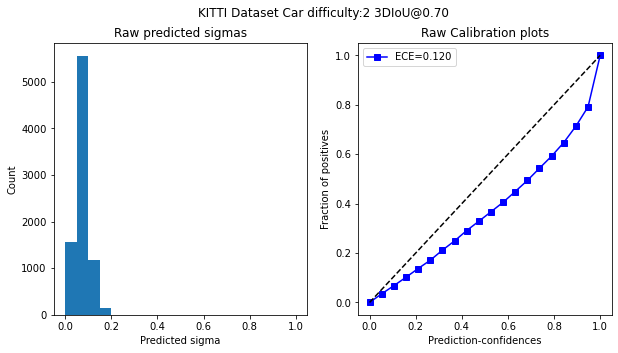

In [31]:
show_calibration(df.Xgt, df.X, df.varX, 20)

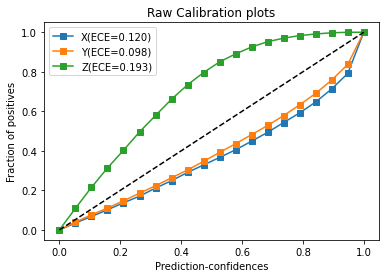

In [37]:
for y_true, y_pred, variance_pred in zip(["Xgt", "Ygt", "Zgt"], ["X", "Y", "Z"], ["varX", "varY", "varZ"]):
    prob_true, prob_pred = reg_calibration_curve(df[y_true], df[y_pred], df[variance_pred], n_bins=20)
    ece = np.abs(prob_true - prob_pred).mean()
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "s-", label=f"{y_pred}(ECE={ece:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlim(-0.05, 1.05)
plt.xlabel("Prediction-confidences")
plt.ylabel("Fraction of positives")
plt.legend()
plt.show()